##############################################
###              Advanced Machine Learnin     #
###           Assignment - Text Data          #
                                            
###Name: Priscilla Shrestha                    #
###Due Date: 27/11/2024                       #
##############################################


**MODEL - 1**

### Processing words as a sequence: The sequence model approach

**Downloading the data**

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4289k      0  0:00:19  0:00:19 --:--:-- 8685k


**Preparing the data**

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok = True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Preparing integer sequence datasets**

In [3]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**A sequence model built on one-hot encoded vector sequences**

In [4]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Lambda(lambda x: tf.one_hot(x, depth=max_tokens),
                        output_shape=(None, max_tokens))(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, None, 20000)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │       5,128,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,128,513 (19.56 MB)

 Trainable params: 5,128,513 (19.56 MB)

 Non-trainable params: 0 (0.00 B)

**Training a first basic sequence model**

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.8927 - loss: 0.2578 - val_accuracy: 0.8778 - val_loss: 0.3154
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.9054 - loss: 0.2382 - val_accuracy: 0.8646 - val_loss: 0.3651
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9115 - loss: 0.2276 - val_accuracy: 0.8754 - val_loss: 0.3139
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.9146 - loss: 0.2178 - val_accuracy: 0.8590 - val_loss: 0.3514
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.9209 - loss: 0.2006 - val_accuracy: 0.8802 - val_loss: 0.3393
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.9259 - loss: 0.1925 - val_accuracy: 0.8766 - val_loss: 0.3519
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.9281 - loss: 0.1808 - val_accuracy: 0.8770 - val_loss: 0.3362
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.9355 - loss: 0.1679 - 

#### Understanding word embeddings

#### Learning word embeddings with the Embedding layer

**Instantiating an `Embedding` layer**

In [5]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

**Model that uses an `Embedding` layer trained from scratch**

In [6]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, None, 256)           │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,194,049 (19.81 MB)

 Trainable params: 5,194,049 (19.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.6226 - loss: 0.6255 - val_accuracy: 0.8054 - val_loss: 0.4588
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.8395 - loss: 0.4135 - val_accuracy: 0.8596 - val_loss: 0.3535
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.8772 - loss: 0.3254 - val_accuracy: 0.8632 - val_loss: 0.3486
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.8999 - loss: 0.2750 - val_accuracy: 0.8492 - val_loss: 0.3751
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9119 - loss: 0.2433 - val_accuracy: 0.8838 - val_loss: 0.3020
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9326 - loss: 0.2027 - val_accuracy: 0.8786 - val_loss: 0.3276
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9415 - loss: 0.1736 - val_accuracy: 0.8822 - val_loss: 0.3259
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9561 - loss: 0.1418 - 

#### Understanding padding and masking

**Using an `Embedding` layer with masking enabled**

In [7]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 256)      │      5,120,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         73,984 │ embedding_2[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,194,049 (19.81 MB)

 Trainable params: 5,194,049 (19.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.6910 - loss: 0.5606 - val_accuracy: 0.7944 - val_loss: 0.4552
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.8721 - loss: 0.3156 - val_accuracy: 0.8664 - val_loss: 0.3115
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.9012 - loss: 0.2448 - val_accuracy: 0.8780 - val_loss: 0.3014
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.9293 - loss: 0.1942 - val_accuracy: 0.8758 - val_loss: 0.3377
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.9448 - loss: 0.1531 - val_accuracy: 0.8762 - val_loss: 0.3590
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9584 - loss: 0.1158 - val_accuracy: 0.8780 - val_loss: 0.3786
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9744 - loss: 0.0795 - val_accuracy: 0.8696 - val_loss: 0.4583
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9797 - loss: 0.0609 - 

#### Using pretrained word embeddings

In [8]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-11-26 00:22:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-26 00:22:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-26 00:22:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**Parsing the GloVe word-embeddings file**

In [9]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


**Preparing the GloVe word-embeddings matrix**

In [10]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Model that uses a pretrained Embedding layer**

In [12]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 100)      │      2,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         34,048 │ embedding_3[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,034,113 (7.76 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.6326 - loss: 0.6335 - val_accuracy: 0.7874 - val_loss: 0.4700
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.7921 - loss: 0.4586 - val_accuracy: 0.8194 - val_loss: 0.4097
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.8236 - loss: 0.3999 - val_accuracy: 0.8346 - val_loss: 0.3809
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.8426 - loss: 0.3622 - val_accuracy: 0.8484 - val_loss: 0.3547
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.8551 - loss: 0.3379 - val_accuracy: 0.8470 - val_loss: 0.3605
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.8635 - loss: 0.3183 - val_accuracy: 0.8696 - val_loss: 0.3205
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.8779 - loss: 0.2992 - val_accuracy: 0.8714 - val_loss: 0.3372
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.8879 - loss: 0.2811 - 

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.9433 - loss: 0.1479 - val_accuracy: 0.8786 - val_loss: 0.3559
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9469 - loss: 0.1403 - val_accuracy: 0.8750 - val_loss: 0.3616
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.9504 - loss: 0.1323 - val_accuracy: 0.8762 - val_loss: 0.3828
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.9552 - loss: 0.1214 - val_accuracy: 0.8662 - val_loss: 0.4030
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.9625 - loss: 0.1077 - val_accuracy: 0.8756 - val_loss: 0.4097
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.9636 - loss: 0.1011 - val_accuracy: 0.8732 - val_loss: 0.4412
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.9659 - loss: 0.0980 - val_accuracy: 0.8724 - val_loss: 0.4587
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.9664 - loss: 0.0893 - 

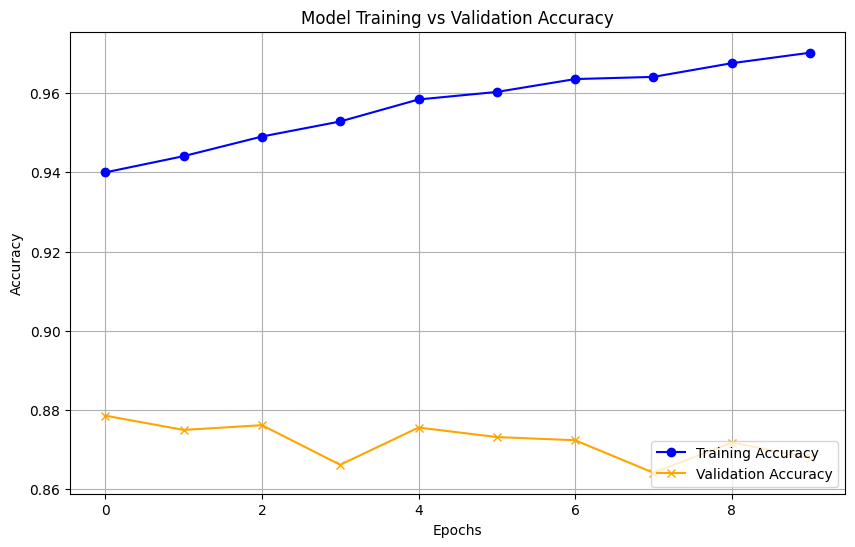

In [116]:
import matplotlib.pyplot as plt

# Assuming 'history_trainable' contains the training history object
# If you have already trained the model and stored the history, you can use it directly
history_trainable = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
accuracy = history_trainable.history['accuracy']
val_accuracy = history_trainable.history['val_accuracy']

# Plot the accuracy
plt.plot(accuracy, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange', marker='x')

# Adding titles and labels
plt.title('Model Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


# MODEL 2- Embeded Layers

In [70]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size2 = 100
base_dir2 = pathlib.Path("aclImdb")
val_dir2 = base_dir2 / "val"
train_dir2 = base_dir2 / "train"

In [71]:
import os
import pathlib

# Step 1: Define Directories
batch_size2 = 100
base_dir2 = pathlib.Path("aclImdb")  # Base directory
train_dir2 = base_dir2 / "train"  # Training directory
val_dir2 = base_dir2 / "val"  # Validation directory

def rename_files_to_txt(directory):
    for category in ("neg", "pos"):
        category_dir = directory / category
        for filename in os.listdir(category_dir):
            if not filename.endswith(".txt"):
                # Construct old and new file paths
                old_path = os.path.join(category_dir, filename)
                new_path = os.path.join(category_dir, filename + ".txt")
                # Rename the file
                os.rename(old_path, new_path)

# Rename files in the training directory
rename_files_to_txt(train_dir2)

# Rename files in the validation directory
rename_files_to_txt(val_dir2)

In [72]:
import os
import pathlib
import shutil
import random
from tensorflow import keras

# Step 1: Download and Extract Dataset
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup  # Remove unsupervised data

# Step 2: Define Directories
batch_size2 = 100
base_dir2 = pathlib.Path("aclImdb")  # Base directory
train_dir2 = base_dir2 / "train"  # Training directory
val_dir2 = base_dir2 / "val"  # Validation directory

# Step 3: Split Data into Train and Validation
for category in ("neg", "pos"):
    os.makedirs(val_dir2 / category, exist_ok=True)
    category_dir = train_dir2 / category
    files2 = os.listdir(category_dir)
    random.Random(1337).shuffle(files2)
    num_val_samples2 = 1000
    val_files2 = files2[-num_val_samples2:]
    # Move validation files
    for fname in val_files2:
        shutil.move(category_dir / fname, val_dir2 / category / fname)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4252k      0  0:00:19  0:00:19 --:--:-- 7283k


In [73]:
train_ds2 = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size2
)
val_ds2 = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size2
)
test_ds2 = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size2
)
text_only_train_ds2 = train_ds2.map(lambda x, y: x)

Found 23000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [74]:
from tensorflow.keras import layers

max_length2 = 150
max_tokens2 = 10000
text_vectorization2 = layers.TextVectorization(
    max_tokens=max_tokens2,
    output_mode="int",
    output_sequence_length=max_length2,
)
text_vectorization2.adapt(text_only_train_ds2)

int_train_ds2 = train_ds2.map(
    lambda x, y: (text_vectorization2(x), y),
    num_parallel_calls=4)
int_val_ds2 = val_ds.map(
    lambda x, y: (text_vectorization2(x), y),
    num_parallel_calls=4)
int_test_ds2 = test_ds.map(
    lambda x, y: (text_vectorization2(x), y),
    num_parallel_calls=4)

In [75]:
import tensorflow as tf

# Create the Embedding layer outside the Lambda layer definition
embedding_layer2 = tf.keras.layers.Embedding(input_dim=max_tokens2, output_dim=256)

inputs2 = keras.Input(shape=(None,), dtype="int64")

embedded2 = embedding_layer2(inputs2)
x2 = layers.Bidirectional(layers.LSTM(32))(embedded2)
x2 = layers.Dropout(0.5)(x2)

outputs2 = layers.Dense(1, activation="sigmoid")(x2)
model2 = keras.Model(inputs2, outputs2)
model2.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_12 (Embedding)             │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
callbacks2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model2.fit(int_train_ds2, validation_data=int_val_ds2, epochs=10, callbacks=callbacks2)
model2 = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model2.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.5692 - loss: 0.6654 - val_accuracy: 0.8152 - val_loss: 0.4454
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7775 - loss: 0.4887 - val_accuracy: 0.8514 - val_loss: 0.3688
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8234 - loss: 0.4126 - val_accuracy: 0.8776 - val_loss: 0.3099
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8495 - loss: 0.3696 - val_accuracy: 0.8248 - val_loss: 0.3804
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8753 - loss: 0.3091 - val_accuracy: 0.8666 - val_loss: 0.3164
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8907 - loss: 0.2815 - val_accuracy: 0.8678 - val_loss: 0.3586
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9007 - loss: 0.2555 - val_accuracy: 0.9132 - val_loss: 0.2411
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9148 - loss: 0.2258 - val_acc

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9516 - loss: 0.1387 - val_accuracy: 0.9240 - val_loss: 0.2767
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9594 - loss: 0.1184 - val_accuracy: 0.9262 - val_loss: 0.2507
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9687 - loss: 0.0919 - val_accuracy: 0.9312 - val_loss: 0.2755
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9760 - loss: 0.0760 - val_accuracy: 0.9320 - val_loss: 0.2749
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9819 - loss: 0.0571 - val_accuracy: 0.9358 - val_loss: 0.2976
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9865 - loss: 0.0473 - val_accuracy: 0.9344 - val_loss: 0.3118
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9884 - loss: 0.0374 - val_accuracy: 0.9364 - val_loss: 0.3445
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9908 - loss: 0.0322 - val_

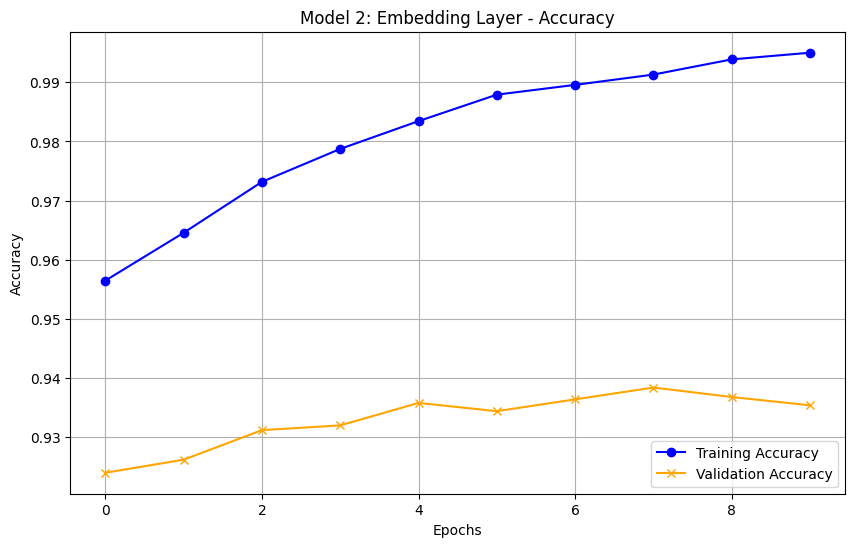

In [117]:
import matplotlib.pyplot as plt

history_trainable2 = model2.fit(int_train_ds2, validation_data=int_val_ds2, epochs=10, callbacks=callbacks2)

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot the accuracy for training and validation
plt.plot(history_trainable2.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(history_trainable2.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='x')

# Adding titles and labels
plt.title('Model 2: Embedding Layer - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


**MODEL 3 - Pre-Trained Work Embeded**

In [77]:
!zip -q glove.6B.zip
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!unzip -q glove.6B.zip


zip error: Nothing to do! (glove.6B.zip)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  3092k      0  0:00:26  0:00:26 --:--:-- 4425k
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n
An
n
n


In [84]:
import numpy as np
import os


glove_dir = "glove.6B"
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

# Change the path to reflect the unzipped directory structure.
path_to_glove_file3 = os.path.join(glove_dir, "glove.6B.100d.txt")


if not os.path.exists(path_to_glove_file3):
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove.6B.zip -d glove.6B

embeddings_index3 = {}
with open(path_to_glove_file3) as f:
    for line in f:
        word3, coefs3 = line.split(maxsplit=1)
        coefs3 = np.fromstring(coefs3, "f", sep=" ")
        embeddings_index3[word3] = coefs3

In [86]:
import numpy as np

# Change the path to reflect the unzipped directory structure.
path_to_glove_file3 = "glove.6B/glove.6B.100d.txt"

embeddings_index3 = {}
with open(path_to_glove_file3) as f:
    for line in f:
        word3, coefs3 = line.split(maxsplit=1)
        coefs3 = np.fromstring(coefs3, "f", sep=" ")
        embeddings_index3[word3] = coefs3

print(f"Found {len(embeddings_index3)} word vectors.")

Found 400000 word vectors.


In [88]:
embedding_dim3 = 100

vocabulary3 = text_vectorization2.get_vocabulary()
word_index3 = dict(zip(vocabulary3, range(len(vocabulary3))))

embedding_matrix3 = np.zeros((max_tokens2, embedding_dim3))
for word, i in word_index3.items():
    if i < max_tokens2:
        embedding_vector3 = embeddings_index3.get(word)
    if embedding_vector3 is not None:
        embedding_matrix3[i] = embedding_vector3

In [89]:
embedding_layer3 = layers.Embedding(
    max_tokens2,
    embedding_dim3,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix3),
    trainable=False,
    mask_zero=True,
)

In [90]:
inputs3 = keras.Input(shape=(None,), dtype="int64")
embedded3 = embedding_layer3(inputs3)
x3 = layers.Bidirectional(layers.LSTM(32))(embedded3)
x3 = layers.Dropout(0.5)(x3)
outputs3 = layers.Dense(1, activation="sigmoid")(x3)
model3 = keras.Model(inputs3, outputs3)
model3.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model3.summary()

callbacks3 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model3.fit(int_train_ds2, validation_data=int_val_ds2, epochs=10, callbacks=callbacks3)
model3 = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model3.evaluate(int_test_ds2)[1]:.3f}")

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, None, 100)      │      1,000,000 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_5 (NotEqual)    │ (None, None)           │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_9           │ (None, 64)             │         34,048 │ embedding_13[0][0],    │
│ (Bidirectional)           │                        │                │ not_equal_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64)             │              0 │ bidirectional_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │             65 │ dropout_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.5856 - loss: 0.6623 - val_accuracy: 0.7516 - val_loss: 0.5268
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7268 - loss: 0.5500 - val_accuracy: 0.7666 - val_loss: 0.4860
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.7609 - loss: 0.4994 - val_accuracy: 0.7780 - val_loss: 0.4700
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.7820 - loss: 0.4626 - val_accuracy: 0.8054 - val_loss: 0.4219
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7908 - loss: 0.4467 - val_accuracy: 0.8010 - val_loss: 0.4239
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.8006 - loss: 0.4286 - val_accuracy: 0.7762 - val_loss: 0.4520
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.8107 - loss: 0.4127 - val_accuracy: 0.8172 - val_loss: 0.4114
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8200 - loss: 0.3983 - va

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8372 - loss: 0.3677 - val_accuracy: 0.8504 - val_loss: 0.3512
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.8410 - loss: 0.3618 - val_accuracy: 0.8518 - val_loss: 0.3457
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.8462 - loss: 0.3528 - val_accuracy: 0.8172 - val_loss: 0.4102
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8512 - loss: 0.3409 - val_accuracy: 0.8502 - val_loss: 0.3534
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8531 - loss: 0.3369 - val_accuracy: 0.8534 - val_loss: 0.3533
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8542 - loss: 0.3306 - val_accuracy: 0.8596 - val_loss: 0.3287
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8603 - loss: 0.3222 - val_accuracy: 0.8384 - val_loss: 0.3678
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8691 - loss: 0.3095 - val

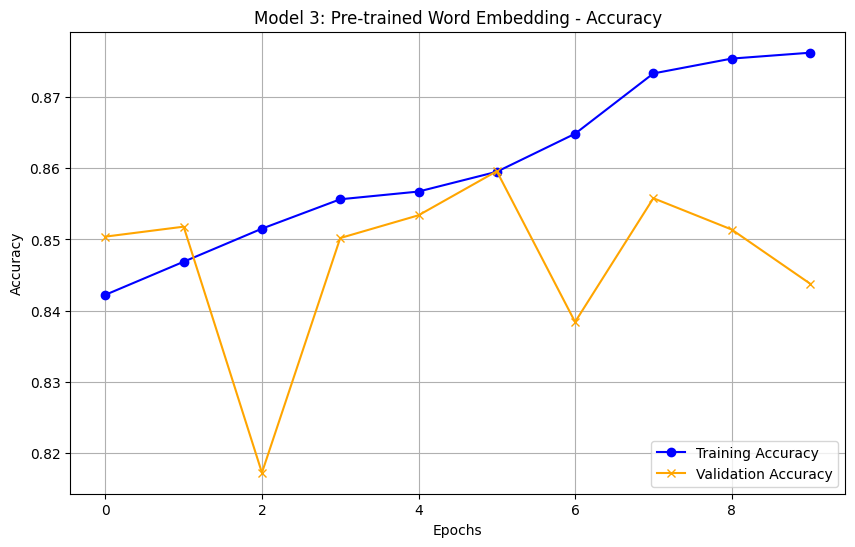

In [118]:
import matplotlib.pyplot as plt

# Assuming 'history_trainable3' contains the training history object
# If you have already trained the model and stored the history, use it directly
history_trainable3 = model3.fit(int_train_ds2, validation_data=int_val_ds2, epochs=10, callbacks=callbacks2)

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot the accuracy for training and validation
plt.plot(history_trainable3.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(history_trainable3.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='x')

# Adding titles and labels
plt.title('Model 3: Pre-trained Word Embedding - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


**MODEL 4 - Adjusted Pre-Trained Word Embeded**

In [92]:
import numpy as np
path_to_glovefile4 = "../glove/glove.6B.300d.txt"  # Changed to reflect likely file name
!wget http://nlp.stanford.edu/data/glove.6B.zip # Download glove.6B.zip
!unzip glove.6B.zip # Unzip the downloaded file
path_to_glovefile4 = "glove.6B.300d.txt" # Update the path variable to the actual file


embeddings_index4 = {}
with open(path_to_glovefile4) as f:
    for line in f:
        word4, coefs4 = line.split(maxsplit=1)
        coefs4 = np.fromstring(coefs4, "f", sep=" ")
        embeddings_index4[word4] = coefs4

--2024-11-26 01:46:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-26 01:46:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-26 01:46:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

gl

In [93]:
embedding_dim4 = 300

vocabulary4 = text_vectorization2.get_vocabulary()
word_index4 = dict(zip(vocabulary4, range(len(vocabulary4))))

embedding_matrix4 = np.zeros((max_tokens2, embedding_dim4))
for word, i in word_index4.items():
    if i < max_tokens2:
        embedding_vector4 = embeddings_index4.get(word4)
    if embedding_vector4 is not None:
        embedding_matrix4[i] = embedding_vector4

In [94]:
embedding_layer4 = layers.Embedding(
    max_tokens2,
    embedding_dim4,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix4),
    trainable=False,
    mask_zero=True,
)

In [95]:
inputs4 = keras.Input(shape=(None,), dtype="int64")
embedded4 = embedding_layer4(inputs4)
x4 = layers.Bidirectional(layers.LSTM(32))(embedded4)
x4 = layers.Dropout(0.5)(x4)
outputs4 = layers.Dense(1, activation="sigmoid")(x4)
model4 = keras.Model(inputs4, outputs4)
model4.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model4.summary()

callbacks4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model4.fit(int_train_ds2, validation_data=int_val_ds2, epochs=30, callbacks=callbacks4)
model4 = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model3.evaluate(int_test_ds2)[1]:.3f}")

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, None, 300)      │      3,000,000 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_7 (NotEqual)    │ (None, None)           │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_10          │ (None, 64)             │         85,248 │ embedding_14[0][0],    │
│ (Bidirectional)           │                        │                │ not_equal_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64)             │              0 │ bidirectional_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1)              │             65 │ dropout_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,085,313 (11.77 MB)

 Trainable params: 85,313 (333.25 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.5030 - loss: 0.7042 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.4967 - loss: 0.6952 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.5089 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5019 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.5010 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5012 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4962 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.4957 - loss: 0.6935 - val

In [106]:
results = []

In [2]:
import pandas as pd

# Define the model names and their accuracies
model_data = {
    "Model": [
        "Model 1: One-hot encoded sequences",
        "Model 2: Embedding layer trained from scratch",
        "Model 3: Pre-trained Word embeddings (100d)",
        "Model 4: Adjusted Pre-trained Word Embeded (300d)"
    ],
    "Accuracy Percentage": [
        86.7,  # Accuracy for Model 1
        58.1,  # Accuracy for Model 2
        82.7,  # Accuracy for Model 3
        82.7,   # Accuracy for Model 4
    ]
}

# Create a pandas DataFrame
df = pd.DataFrame(model_data)

# Print the table in a tabular format
print(df.to_string(index=False))
df.to_csv("model_accuracy_comparison.csv", index=False)



                                            Model  Accuracy Percentage
               Model 1: One-hot encoded sequences                 86.7
    Model 2: Embedding layer trained from scratch                 58.1
      Model 3: Pre-trained Word embeddings (100d)                 82.7
Model 4: Adjusted Pre-trained Word Embeded (300d)                 82.7
